In [7]:
%pylab inline


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [1]:
from SuperNovaSurveySim import SDSSSuperNova, LowZSuperNova, SNLSSuperNova, HSTSuperNova

In [4]:
from astropy.table import Table
jlaSet = Table.read("jla_lcparams.txt",format='ascii')

snls = jlaSet['set'] == 1
sdss = jlaSet['set'] == 2
lowz = jlaSet['set'] == 3
hst  = jlaSet['set'] == 4

In [5]:
snData = Table( names = ['zcmb',
                           'mb','dmb',
                           'color','dcolor',
                           'x1','dx1',
                           'survey'],
                 dtype=[float,
                        float,float,
                        float,float,
                       float,float,
                       '|S4'])

for i in range(len(jlaSet[lowz])):
    
    sn = LowZSuperNova()
    snData.add_row(sn.GetObsParams())
    


for i in range(len(jlaSet[sdss])):
    
    sn = SDSSSuperNova()
    snData.add_row(sn.GetObsParams())
    
    
for i in range(len(jlaSet[snls])):
    
    sn = SNLSSuperNova()
    snData.add_row(sn.GetObsParams()) 


for i in range(len(jlaSet[hst])):
    
    sn = HSTSuperNova()
    snData.add_row(sn.GetObsParams())

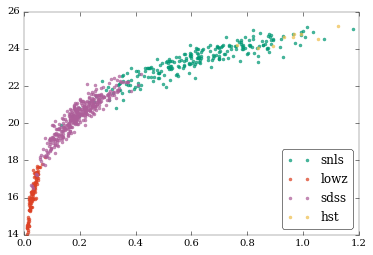

In [8]:
for survey in ['snls','lowz','sdss','hst']:

    surCondition = snData['survey'] == survey

    plot(snData[surCondition]['zcmb'],snData[surCondition]['mb'],'.',label=survey,alpha=.7)
    
ylim(bottom=14,top=26)    
legend(loc=4)

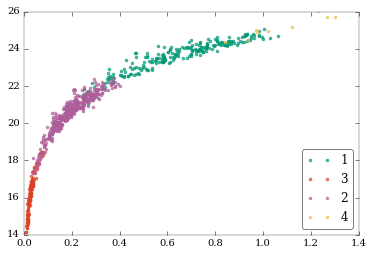

In [9]:
for survey in [1,3,2,4]:

    surCondition = jlaSet['set'] == survey

    plot(jlaSet[surCondition]['zcmb'],jlaSet[surCondition]['mb'],'.',label=survey,alpha=.7)
    
ylim(bottom=14,top=26)     
legend(loc=4)